Goals
- Classify antibody sequences as human or non-human 

In [1]:
!pip install -q biopython transformers datasets huggingface_hub accelerate seaborn ipywidgets scipy


In [3]:
from huggingface_hub import notebook_login
notebook_login()

In [9]:
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

import torch
from torch.nn.functional import softmax


### Loading Data

In [11]:
df = pd.read_csv("/Users/lib_laptop/Downloads/nmep_antibody_data.csv")

In [12]:
#List out unique values
pd.unique(df['species'])

#Map the values
di = {'human': 1, 'mouse': 0, 'rat':0,'rhesus':0, 'rabbit':0 }
df['species'] = df['species'].replace(di)

In [111]:
class_0_df = df[df['species'] == 0]
class_1_df = df[df['species'] == 1]

num_class_0 = len(class_0_df)

class_1_sample = class_1_df.sample(num_class_0)

balanced_df = pd.concat([class_0_df, class_1_sample])

balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

### Dataset loading & Preparation

In [113]:
from datasets import Dataset
dataset = Dataset.from_pandas(balanced_df)
sequences = dataset['sequence']
labels = dataset['species']

train_sequences, test_sequences, train_labels, test_labels = train_test_split(sequences, labels, test_size=0.1, random_state=42)
train_sequences, val_sequences, train_labels, val_labels = train_test_split(train_sequences, train_labels, test_size=0.05, random_state=42)

### Tokenising the datasets

In [114]:
from torch.utils.data import Dataset
import torch

class CustomDataset(Dataset):
    def __init__(self, sequences, labels, tokenizer, max_length=128):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        
        tokenized = self.tokenizer(sequence, padding="max_length", truncation=True, max_length=self.max_length)
        input_ids = torch.tensor(tokenized['input_ids'], dtype=torch.long)
        attention_mask = torch.tensor(tokenized['attention_mask'], dtype=torch.long)
        label = torch.tensor(label, dtype=torch.long)

        return input_ids, attention_mask, label


In [115]:
tokeniser = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")

train_dataset = CustomDataset(train_sequences, train_labels, tokeniser)
val_dataset = CustomDataset(val_sequences, val_labels, tokeniser)
test_dataset = CustomDataset(test_sequences, test_labels, tokeniser)

batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


### Define Neural Network

In [116]:
import wandb
wandb.init(project="transformer-attempt-final", entity="sarrahrose")

test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▆▇▇▇▇████
train_loss,█▃▂▂▂▂▁▁▁▁
val_acc,▂█▅▁▅▅██▁▆
val_f1,▁▅▃█▂▂▄▄▃▂
val_loss,█▃▂▄▃▃▁▂▃▃
test_acc,0.91704
test_f1,0.89314
test_loss,0.22296


In [118]:
import torch.nn as nn
import torch.optim as optim

class GoodModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GoodModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)  
        self.batch_norm = nn.BatchNorm1d(hidden_dim)  
        self.relu = nn.ReLU() 
        self.fc2 = nn.Linear(hidden_dim, output_dim) 
    def forward(self, x, attention_mask):
        embedded = self.embedding(x) 
        masked_embedded = embedded * attention_mask.unsqueeze(2)  
        summed_embedded = torch.sum(masked_embedded, dim=1)  
        hidden = self.fc1(summed_embedded)  
        hidden = self.batch_norm(hidden) 
        hidden = self.relu(hidden)  
        output = self.fc2(hidden)  
        return output   

input_dim = len(tokeniser)  
hidden_dim = 128
output_dim = 2

model = GoodModel(input_dim, hidden_dim, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [120]:
def train(model, iterator, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for batch in iterator:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        predictions = model(input_ids, attention_mask)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        _, predicted = torch.max(predictions, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
    
    train_loss = total_loss / len(iterator)
    train_acc = correct_predictions / total_predictions
    
    return train_loss, train_acc


def evaluate(model, iterator, criterion):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in iterator:
            input_ids, attention_mask, labels = batch
            predictions = model(input_ids, attention_mask)
            loss = criterion(predictions, labels)
            total_loss += loss.item()
            
            _, predicted = torch.max(predictions, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            
            all_preds.extend(predicted.tolist())
            all_labels.extend(labels.tolist())
    
    f1 = f1_score(all_labels, all_preds, average='weighted')  
    return total_loss / len(iterator), correct_predictions / total_predictions, f1

In [121]:
N_EPOCHS = 10
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)  
    val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion)
    
    wandb.log({"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc, "val_f1": val_f1})
    
    print(f'Epoch: {epoch + 1:02}')
    print(f'\tTraining Loss: {train_loss:.3f} | Training Acc: {train_acc * 100:.2f}% | Validation Loss: {val_loss:.3f} | Validation Acc: {val_acc * 100:.2f}% | Validation F1: {val_f1:.2f}')

Epoch: 01
	Training Loss: 0.083 | Training Acc: 97.34% | Validation Loss: 0.056 | Validation Acc: 98.31% | Validation F1: 0.98
Epoch: 02
	Training Loss: 0.063 | Training Acc: 98.05% | Validation Loss: 0.063 | Validation Acc: 98.05% | Validation F1: 0.98
Epoch: 03
	Training Loss: 0.058 | Training Acc: 98.19% | Validation Loss: 0.052 | Validation Acc: 98.49% | Validation F1: 0.98
Epoch: 04
	Training Loss: 0.056 | Training Acc: 98.26% | Validation Loss: 0.048 | Validation Acc: 98.61% | Validation F1: 0.99
Epoch: 05
	Training Loss: 0.055 | Training Acc: 98.29% | Validation Loss: 0.047 | Validation Acc: 98.61% | Validation F1: 0.99
Epoch: 06
	Training Loss: 0.054 | Training Acc: 98.32% | Validation Loss: 0.045 | Validation Acc: 98.72% | Validation F1: 0.99
Epoch: 07
	Training Loss: 0.053 | Training Acc: 98.35% | Validation Loss: 0.044 | Validation Acc: 98.74% | Validation F1: 0.99
Epoch: 08
	Training Loss: 0.052 | Training Acc: 98.36% | Validation Loss: 0.047 | Validation Acc: 98.64% | Vali

In [122]:
test_loss, test_acc, test_f1 = evaluate(model, test_loader, criterion)

wandb.log({"test_loss": test_loss, "test_acc": test_acc, "test_f1": test_f1})

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}% | Test F1: {test_f1:.2f}')

Test Loss: 0.042 | Test Acc: 98.79% | Test F1: 0.99


In [123]:
torch.save(model, 'entire_model_esm.pth')

In [124]:
newdf = pd.read_csv("/Users/lib_laptop/Downloads/inference_dataset - Sheet1.csv")
newdf = newdf.rename(columns={"Species": "species", "VH": "sequence"})

#Map the values
di = {'Human': 1, 'Mouse': 0, 'Chimeric':0,'Humanized':0, 'Humanized/Chimeric':0 }
newdf['species'] = newdf['species'].replace(di)


In [127]:
from datasets import Dataset

inf_dataset = Dataset.from_pandas(newdf)
inf_sequences = inf_dataset['sequence']
inf_labels = inf_dataset['species']

inference_dataset = CustomDataset(inf_sequences, inf_labels, tokeniser)


batch_size = 32 
inference_loader = DataLoader(inference_dataset, batch_size=batch_size, shuffle = False)

In [130]:
def run_inference(model, loader):
    model.eval()  
    predictions = []
    
    with torch.no_grad():  
        for batch in loader:
            input_ids, attention_mask, _ = batch
            outputs = model(input_ids, attention_mask)
            probs = softmax(outputs, dim=1)  
            predictions.extend(probs.cpu().numpy())  

    return predictions


In [131]:
predicted_probs = run_inference(model, inference_loader)
predicted_probabilities_df = pd.DataFrame(predicted_probs, columns=['Probability_Class_1', 'Probability_Class_2'])
inference_results_df = pd.concat([newdf, predicted_probabilities_df], axis=1)
inference_results_df.to_csv('inference_results_esm.csv', index=False)

In [139]:
from scipy.stats import spearmanr

inference_results_df = pd.read_csv('inference_results_esm.csv')

immunogenicity = inference_results_df['Immunogenicity']
predicted_probabilities = inference_results_df['Probability_Class_2']

correlation, p_value = spearmanr(predicted_probabilities, immunogenicity)

print(f'Spearman Correlation: {correlation:.3f}')
print(f'P-Value: {p_value:.3f}')


Spearman Correlation: -0.376
P-Value: 0.000


In [141]:
#attach original species
spec = pd.read_csv("/Users/lib_laptop/Downloads/inference_dataset - Sheet1.csv")
spec = spec.rename(columns={"Species": "species_type", "VH": "sequence"})
spec.head()
inference_results_df['species_type'] = spec['species_type']
inference_results_df.head()


,Antibody,Immunogenicity,species,sequence,Probability_Class_1,Probability_Class_2,species_type
0,3F8,100.0,0,QVQLKESGPGLVAPSQSLSITCTVSGFSVTNYGVHWVRQPPGKGLE...,0.999876,0.000124,Mouse
1,Abagovomab,68.1,0,QVKLQESGAELARPGASVKLSCKASGYTFTNYWMQWVKQRPGQGLD...,0.999422,0.000578,Mouse
2,Abciximab,35.5,0,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYVHWVKQRPEQGLE...,0.998583,0.001418,Chimeric
3,Abrilumab,0.4,1,QVQLVQSGAEVKKPGASVKVSCKVSGYTLSDLSIHWVRQAPGKGLE...,0.726166,0.273834,Human
4,Actoxumab,0.0,1,QVQLVESGGGVVQPGRSLRLSCAASGFSFSNYGMHWVRQAPGKGLE...,0.000425,0.999575,Human


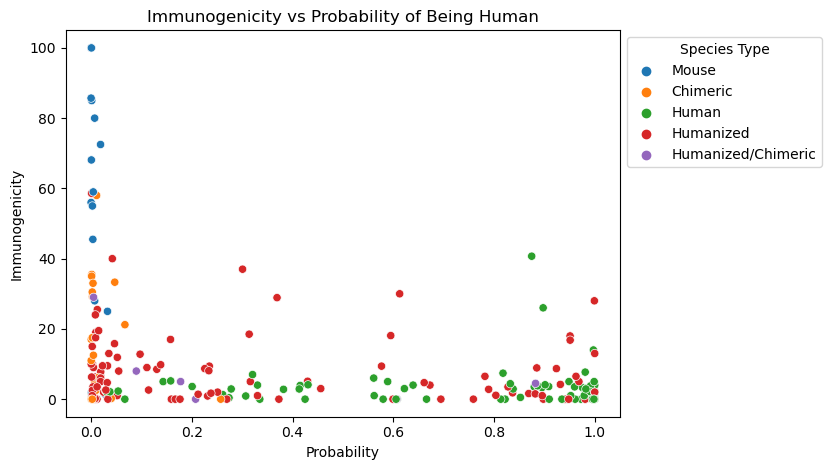

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=inference_results_df, x='Probability_Class_2', y='Immunogenicity', hue='species_type')

plt.title('Immunogenicity vs Probability of Being Human')
plt.xlabel('Probability')
plt.ylabel('Immunogenicity')
plt.tight_layout()
plt.legend(title='Species Type', bbox_to_anchor=(1.00, 1), loc='upper left')
plt.show()
